In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import st_remux as st

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical



%matplotlib inline

Using TensorFlow backend.
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/trial_env/l

In [2]:
# Config

highpain = 'Pain_data/final_data/high_pain'
lowpain= 'Pain_data/final_data/low_pain'
nopain= 'Pain_data/final_data/no_pain'

fs = 4000
win_len = 40

use_filter = 0   # weird results if we use python filtering

use_matlab_backend = 0

#high = np.genfromtxt(highpain, delimiter=',')
#no = np.genfromtxt(nopain, delimiter=',')

In [3]:
if use_matlab_backend:
    print('Using MATLAB signal processing backend')
    # high_dir = 'datasets/high/'
    # low_dir = 'datasets/low/'

    high_dir = 'EMG_data/power_spectrum_for_cnn_input/high/'
    low_dir = 'EMG_data/power_spectrum_for_cnn_input/low/'

    def generate_3darray(directory):
        files = os.listdir(directory)
        dims = np.genfromtxt(directory + files[0], delimiter=',').shape
        length = len(files)
        arr = np.zeros((length, dims[0], dims[1]))

        for idx, val in enumerate(files):
            arr[idx] = np.genfromtxt(directory + val, delimiter=',')

        return arr

    hi = generate_3darray(high_dir)
    lo = generate_3darray(low_dir)
    
else: 
    print('Using native backend')
    hi = st.raw_to_arr(highpain, fs, win_len, 0)
    low= st.raw_to_arr(lowpain, fs, win_len, 0)
    no = st.raw_to_arr(nopain, fs, win_len, 0)

X = np.concatenate((hi, no, low))

hi_Y = np.ones(len(hi), dtype=int)*2
low_Y= np.ones(len(low), dtype=int)*1
no_Y = np.zeros(len(no), dtype=int)

Y = np.concatenate((hi_Y, no_Y, low_Y))

Using native backend
['.DS_Store', 'pain_large.csv']
ydim=16 xdim=40
['pain_low.csv']
ydim=16 xdim=40
['.DS_Store', 'nopain.csv']
ydim=16 xdim=40


In [4]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.1)

In [5]:
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Testing data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (2572, 16, 40) (2572,)
Testing data shape:  (286, 16, 40) (286,)


In [6]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs: ', nClasses)
print('Output classes: ', classes)

Total number of outputs:  3
Output classes:  [0 1 2]


Text(0.5,1,'Ground Truth: 2')

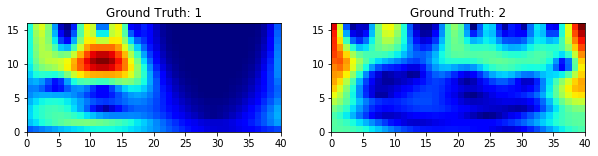

In [7]:
plt.figure(figsize=[10,2])

# Display first image in training set
plt.subplot(121)
plt.pcolormesh(train_X[0,:,:], cmap='jet')
plt.title("Ground Truth: {}".format(train_Y[0]))

# Display second image in testing set
plt.subplot(122)
plt.pcolormesh(test_X[1], cmap='jet')
plt.title("Ground Truth: {}".format(test_Y[1]))

In [8]:
ydim = train_X[0].shape[0]
xdim = train_X[0].shape[1]
train_X = train_X.reshape(-1, ydim, xdim, 1)
test_X = test_X.reshape(-1, ydim, xdim, 1)
train_X.shape, test_X.shape

((2572, 16, 40, 1), (286, 16, 40, 1))

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [10]:
# Change labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# See the difference?
print('Original label: ', train_Y[0])
print('After conversion to one-hot: ', train_Y_one_hot[0])

Original label:  1
After conversion to one-hot:  [0. 1. 0.]


In [11]:
train_Y_one_hot.shape
test_Y_one_hot.shape

(286, 3)

In [12]:
# Partition data for 80% training and 20% validation
# should reduce overfitting and boost test performance

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2)

train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((2057, 16, 40, 1), (515, 16, 40, 1), (2057, 3), (515, 3))

In [13]:
# let's get down to business
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [14]:
# Parameters
batch_size = 32
epochs = 50
num_classes = nClasses

In [15]:
pain_model = Sequential()
pain_model.add(
    Conv2D(
        32, 
        kernel_size=(3, 3), 
        activation='linear', 
        input_shape=(ydim, xdim, 1), 
        padding='same'))
pain_model.add(LeakyReLU(alpha=0.1))
pain_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
pain_model.add(Dropout(0.25))
pain_model.add(
    Conv2D(
        64,
        (3, 3),
        activation='linear',
        padding='same'))
pain_model.add(LeakyReLU(alpha=0.1))
pain_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
pain_model.add(Dropout(0.25))
pain_model.add(
    Conv2D(
        128,
        (3, 3),
        activation='linear',
        padding='same'))
pain_model.add(LeakyReLU(alpha=0.1))
pain_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
pain_model.add(Dropout(0.4))
pain_model.add(Flatten())
pain_model.add(Dense(128, activation='linear'))
pain_model.add(LeakyReLU(alpha=0.1))
pain_model.add(Dropout(0.3))
pain_model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
pain_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

In [17]:
pain_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 40, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 40, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 20, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 20, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 20, 64)         18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 20, 64)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 10, 64)        

In [18]:
pain_train = pain_model.fit(train_X,train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label))

Instructions for updating:
Use tf.cast instead.
Train on 2057 samples, validate on 515 samples
Epoch 1/50
2057/2057 [==============================] - 4s 2ms/step - loss: 1.0979 - accuracy: 0.3495 - val_loss: 1.0967 - val_accuracy: 0.3340
Epoch 2/50
2057/2057 [==============================] - 3s 1ms/step - loss: 1.0842 - accuracy: 0.3913 - val_loss: 1.0659 - val_accuracy: 0.4175
Epoch 3/50
2057/2057 [==============================] - 3s 1ms/step - loss: 1.0782 - accuracy: 0.3967 - val_loss: 1.0604 - val_accuracy: 0.4583
Epoch 4/50
2057/2057 [==============================] - 3s 1ms/step - loss: 1.0629 - accuracy: 0.4152 - val_loss: 1.0469 - val_accuracy: 0.4311
Epoch 5/50
2057/2057 [==============================] - 3s 1ms/step - loss: 1.0492 - accuracy: 0.4409 - val_loss: 1.0304 - val_accuracy: 0.4544
Epoch 6/50
2057/2057 [==============================] - 3s 1ms/step - loss: 1.0402 - accuracy: 0.4443 - val_loss: 1.0265 - val_accuracy: 0.4136
Epoch 7/50
2057/2057 [===================

In [19]:
test_eval = pain_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [20]:
print('Test loss: ', test_eval[0])
print('Test accuracy: ', test_eval[1])

Test loss:  1.0799371237521405
Test accuracy:  0.4720279574394226


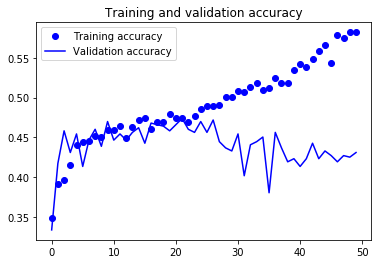

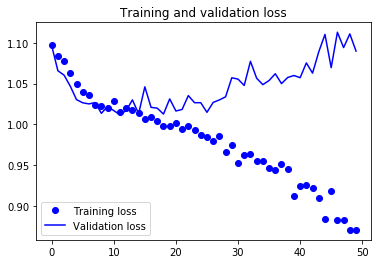

In [21]:
accuracy = pain_train.history['accuracy']
val_accuracy = pain_train.history['val_accuracy']
loss = pain_train.history['loss']
val_loss = pain_train.history['val_loss']
epoch = range(len(accuracy))
plt.plot(epoch, accuracy, 'bo', label='Training accuracy')
plt.plot(epoch, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
predicted_classes = pain_model.predict(test_X)

In [23]:
predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

In [24]:
predicted_classes.shape, test_Y.shape

((286,), (286,))

Found 141 correct labels


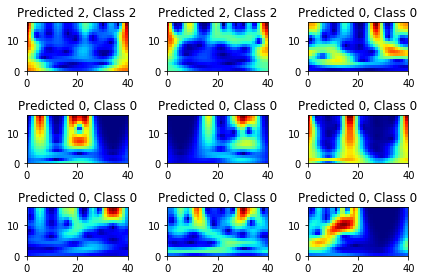

In [25]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct, in enumerate(correct[:9]):
    plt.subplot(3, 3, i+1)
    plt.pcolormesh(test_X[correct].reshape(ydim, xdim), cmap='jet')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 145 incorrect labels


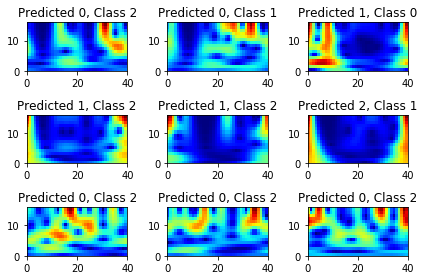

In [26]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect, in enumerate(incorrect[:9]):
    plt.subplot(3, 3, i+1)
    plt.pcolormesh(test_X[incorrect].reshape(ydim, xdim), cmap='jet')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

In [27]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.47      0.94      0.62       109
    Class 1       0.48      0.17      0.25        93
    Class 2       0.68      0.27      0.39        84

avg / total       0.53      0.49      0.43       286

